## Code Explanation

### 1. Log-Relative Prices (`lr_*`)

To capture the relative change in prices between time periods, we calculate the log-relative returns for the stock's open, high, low, and close prices. The log-relative price is defined as:

\[
lr\_price = \log\left(\frac{\text{price}}{\text{previous\_close}}\right)
\]

where `price` refers to open, high, low, or close prices, and `previous_close` is the close price of the previous time period.

### 2. Target Variable Creation (`lr_close_t+1`)

The target variable for prediction is the log-relative close price for the next time period, `lr_close_t+1`. This is achieved by shifting the `lr_close` column by one period:

\[
lr\_close\_t+1 = lr\_close.shift(-1)
\]

### 3. Z-Score Normalization for Volume (`z_score_volume`)

To normalize the trading volume and reduce the impact of varying scales, we use Z-score normalization. The Z-score for volume is computed as:

\[
z\_score\_volume = \frac{\text{volume} - \text{rolling\_mean}}{\text{rolling\_std}}
\]

where `rolling_mean` and `rolling_std` are the rolling mean and standard deviation of the volume over a specified window.

### 4. Simple Moving Average (SMA) based on `lr_close`

We calculate the Simple Moving Average (SMA) using the `lr_close` values over a rolling window. The SMA is defined as:

\[
SMA\_lr\_close = \frac{1}{n} \sum_{i=0}^{n-1} lr\_close_i
\]

where `n` is the window size, and `lr_close_i` represents the log-relative close prices.

### 5. Performance Metrics

The model's performance is evaluated using the following metrics:

- **Root Mean Squared Error (RMSE):**

\[
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
\]

- **Mean Absolute Error (MAE):**

\[
MAE = \frac{\text{1}}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
\]

- **R-squared (R²):**

\[
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
\]

where \(y_i\) is the actual value, \(\hat{y}_i\) is the predicted value, and \(\bar{y}\) is the mean of the actual values.

### 6. Trend Accuracy

Trend accuracy measures how often the model correctly predicts the direction of price movement. It is defined as the proportion of times the predicted trend matches the actual trend:

\[
\text{Trend Accuracy} = \frac{\text{Number of Correct Trends}}{\text{Total Number of Predictions}}
\]

The trend is determined by the sign of the difference between consecutive points, calculated as:

\[
\text{Trend} = \text{sign}(y_{t+1} - y_t)
\]


Training Data - RMSE: 0.0007355025997081271, MAE: 0.00015723299323194766, R²: 0.6626196835117885
Testing Data - RMSE: 0.0008869740166543987, MAE: 0.00042352245266906154, R²: -0.0012721153383443706
                                            Model  Train RMSE  Test RMSE  \
0  Tuned Random Forest with SMA based on lr_close    0.000736   0.000887   

   Train MAE  Test MAE  Train R²   Test R²  
0   0.000157  0.000424   0.66262 -0.001272  


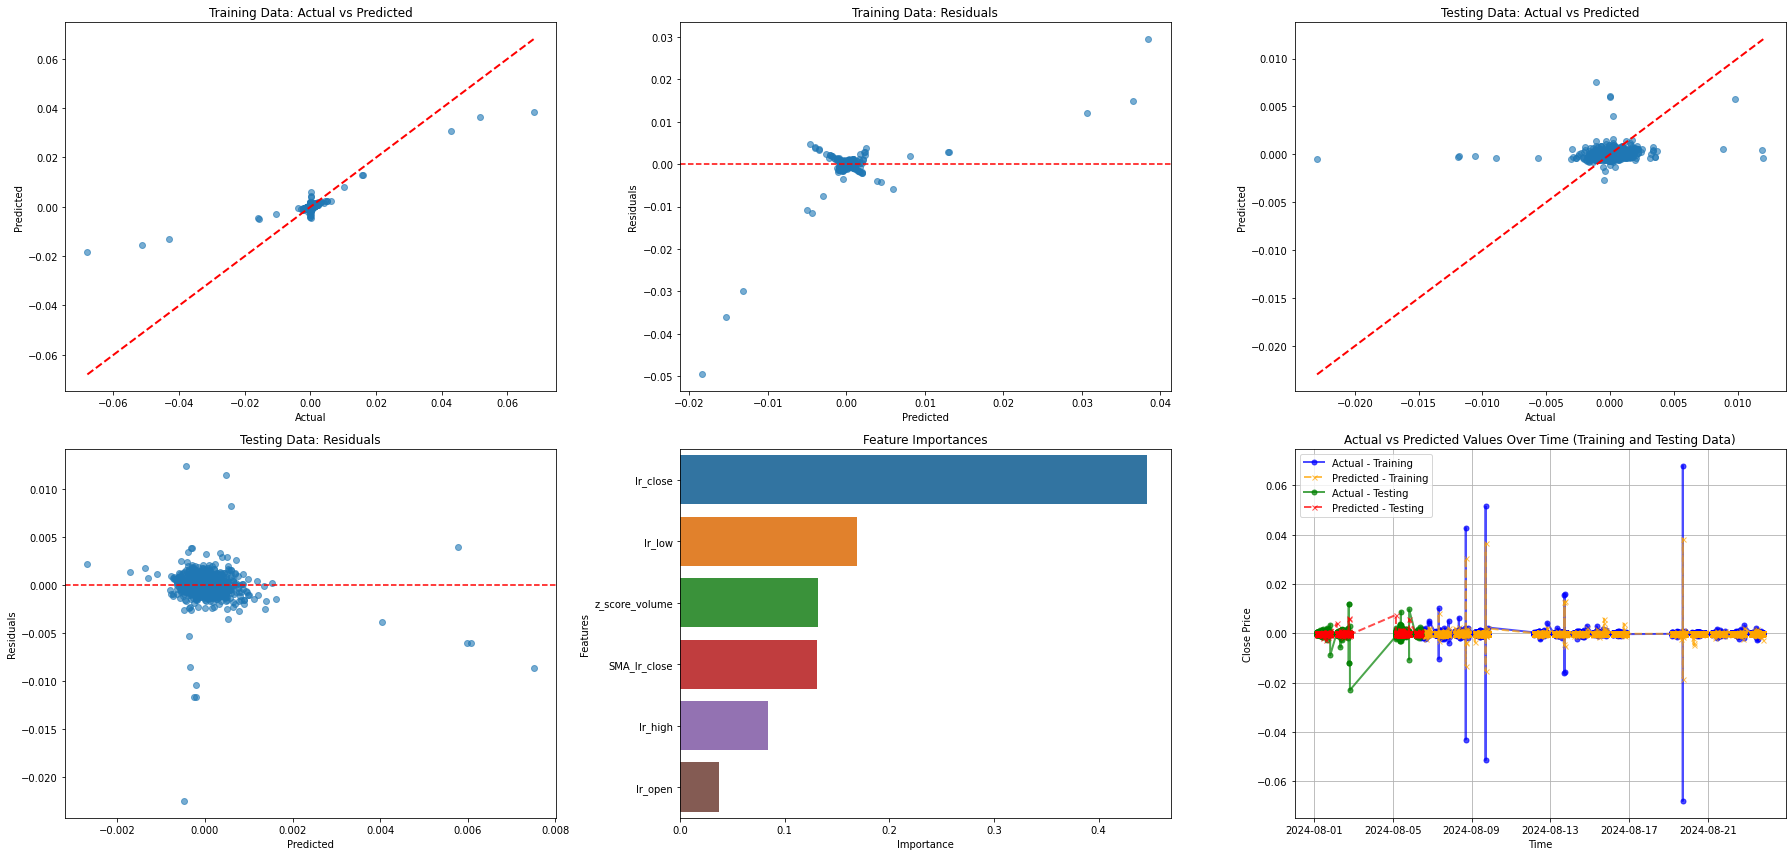

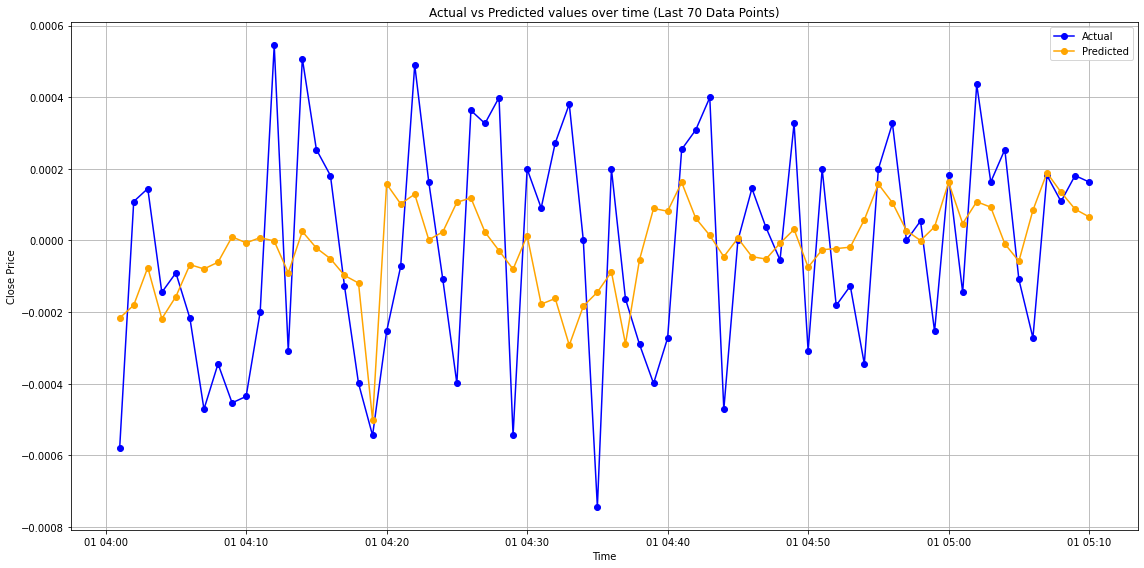

Trend Accuracy on Testing Data: 57.74%
                                            Model  Train RMSE  Test RMSE  \
0  Tuned Random Forest with SMA based on lr_close    0.000736   0.000887   

   Train MAE  Test MAE  Train R²   Test R²  Trend Accuracy  
0   0.000157  0.000424   0.66262 -0.001272       57.738647  


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load and prepare data
def load_and_prepare_data(filepath, sort_by='timestamp', ascending=False):
    data = pd.read_csv(filepath)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data.set_index('timestamp', inplace=True)
    data.sort_values(by=sort_by, ascending=ascending, inplace=True)

    for col in ['open', 'high', 'low', 'close']:
        new_col = 'lr_' + col
        data[new_col] = np.log(data[col] / data['close'].shift(-1))
    
    return data

# Function to create the target variable
def create_target_variable(data, shift_by=1):
    data['lr_close_t+1'] = data['lr_close'].shift(shift_by)
    return data

# Function to apply Z-score normalization to the volume
def z_score_volume(data, window=60):
    rolling_mean = data['volume'].rolling(window).mean()
    rolling_std = data['volume'].rolling(window).std()
    data['z_score_volume'] = (data['volume'] - rolling_mean) / rolling_std
    return data

# Function to calculate SMA based on lr_close
def add_sma_feature(data, window=10):
    data['SMA_lr_close'] = data['lr_close'].rolling(window=window).mean()
    return data

# Load and prepare the dataset
data = load_and_prepare_data('SPY_2024-08.csv')

# Apply feature engineering steps
data = create_target_variable(data, shift_by=1)
data = z_score_volume(data, window=60)
data = add_sma_feature(data, window=10)  # Add SMA based on lr_close with a 10-period window

# Drop NaN values resulting from shifting operations and SMA calculation
data.dropna(inplace=True)

# Function to split data into training and testing sets
def split_data(data, features, target, test_size=0.2, shuffle=False):
    X = data[features]
    y = data[target]
    return train_test_split(X, y, test_size=test_size, shuffle=shuffle)

# Define the features and target variable
features = ['lr_open', 'lr_high', 'lr_low', 'lr_close', 'z_score_volume', 'SMA_lr_close']
target = 'lr_close_t+1'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = split_data(data, features, target, test_size=0.2, shuffle=False)

# Hyperparameter tuning or predefined model (as before)
best_params = {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
best_rfr_model = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2, n_estimators=300, random_state=42)

# Train the Random Forest model using the best hyperparameters
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate and save metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate and save metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Store results in a dictionary
results = {
    'Model': ['Tuned Random Forest with SMA based on lr_close'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
}

# Convert the dictionary to a DataFrame and print it
results_df = pd.DataFrame(results)
print(results_df)

# Save the performance metrics to a CSV file
results_df.to_csv('tuned_model_performance_metrics_with_lr_close_sma.csv', index=False)

# Function to plot Random Forest Regressor results
def plot_rfr_results(y_train, y_train_pred, y_test, y_test_pred, feature_importances, feature_names, data, last_n=70):
    feature_importances_df = pd.DataFrame(feature_importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)

    plt.figure(figsize=(25, 12))

    plt.subplot(2, 3, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.6)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Training Data: Actual vs Predicted')

    plt.subplot(2, 3, 2)
    plt.scatter(y_train_pred, y_train - y_train_pred, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Training Data: Residuals')

    plt.subplot(2, 3, 3)
    plt.scatter(y_test, y_test_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Testing Data: Actual vs Predicted')

    plt.subplot(2, 3, 4)
    plt.scatter(y_test_pred, y_test - y_test_pred, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Testing Data: Residuals')

    plt.subplot(2, 3, 5)
    sns.barplot(x=feature_importances_df['Importance'], y=feature_importances_df.index)
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Features')

    plt.subplot(2, 3, 6)
    plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
    plt.plot(y_train.index, y_train_pred, label='Predicted - Training', color='orange', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)
    plt.plot(y_test.index, y_test, label='Actual - Testing', color='green', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
    plt.plot(y_test.index, y_test_pred, label='Predicted - Testing', color='red', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

    plt.title('Actual vs Predicted Values Over Time (Training and Testing Data)')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 8))
    time_series = data.index[-last_n:]
    y_test_actual_last_n = y_test[-last_n:]
    y_test_pred_last_n = y_test_pred[-last_n:]

    plt.plot(time_series, y_test_actual_last_n, label='Actual', color='blue', marker='o')
    plt.plot(time_series, y_test_pred_last_n, label='Predicted', color='orange', marker='o')

    plt.title(f'Actual vs Predicted values over time (Last {last_n} Data Points)')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the plot function to visualize the results
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=best_rfr_model.feature_importances_,
    feature_names=X_train.columns,
    data=data,
    last_n=70
)

# Calculate the trend direction accuracy
def calculate_trend_accuracy(y_true, y_pred):
    # Calculate the difference between consecutive points to get the trend
    actual_trend = np.sign(np.diff(y_true))
    predicted_trend = np.sign(np.diff(y_pred))
    
    # Calculate how many times the model correctly captured the trend
    trend_accuracy = np.mean(actual_trend == predicted_trend)
    
    return trend_accuracy

# Calculate trend accuracy for the testing data
trend_accuracy = calculate_trend_accuracy(y_test, y_test_pred)

# Print the trend accuracy
print(f"Trend Accuracy on Testing Data: {trend_accuracy * 100:.2f}%")

# Store trend accuracy in the results dictionary
results['Trend Accuracy'] = [trend_accuracy * 100]

# Convert the dictionary to a DataFrame and print it
results_df = pd.DataFrame(results)
print(results_df)

# Save the updated performance metrics to a CSV file
results_df.to_csv('tuned_model_performance_metrics_with_lr_close_sma_and_trend_accuracy.csv', index=False)
